<a href="https://colab.research.google.com/github/Bolorooo24/Classification_Projects/blob/main/action_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#import libs
import cv2
import os
import random
import matplotlib.pylab as plt
from glob import glob
import pandas as pd
import numpy as np
import pickle

import tensorflow as tf
import keras
from keras.models import *
from keras.layers import *
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.preprocessing.image import *
from keras.callbacks import EarlyStopping
from keras import regularizers,optimizers
from keras.callbacks import LearningRateScheduler
from keras import *
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
train_run = glob(os.path.join('/content/drive/MyDrive/action_recognition/walk_run_train/train_run', "*.png"))


In [5]:
train_walk = glob(os.path.join('/content/drive/MyDrive/action_recognition/walk_run_train/train_walk', "*.png"))

In [6]:
train = pd.DataFrame()
train['file'] = train_run + train_walk
train.head()


,file
0,/content/drive/MyDrive/action_recognition/walk...
1,/content/drive/MyDrive/action_recognition/walk...
2,/content/drive/MyDrive/action_recognition/walk...
3,/content/drive/MyDrive/action_recognition/walk...
4,/content/drive/MyDrive/action_recognition/walk...


In [7]:
test_run = glob(os.path.join('/content/drive/MyDrive/action_recognition/walk_run_test/run_test', "*.png"))

In [8]:
test_walk = glob(os.path.join('/content/drive/MyDrive/action_recognition/walk_run_test/walk_test', "*.png"))

In [9]:
test = pd.DataFrame()
test['file'] = test_run + test_walk
test.head()


,file
0,/content/drive/MyDrive/action_recognition/walk...
1,/content/drive/MyDrive/action_recognition/walk...
2,/content/drive/MyDrive/action_recognition/walk...
3,/content/drive/MyDrive/action_recognition/walk...
4,/content/drive/MyDrive/action_recognition/walk...


In [10]:
train['label'] = [1 if j in train_run else 0 for j in train['file']]
train.head()




,file,label
0,/content/drive/MyDrive/action_recognition/walk...,1
1,/content/drive/MyDrive/action_recognition/walk...,1
2,/content/drive/MyDrive/action_recognition/walk...,1
3,/content/drive/MyDrive/action_recognition/walk...,1
4,/content/drive/MyDrive/action_recognition/walk...,1


In [11]:
test['label'] = [1 if j in test_run else 0 for j in test['file']]
test.head()

,file,label
0,/content/drive/MyDrive/action_recognition/walk...,1
1,/content/drive/MyDrive/action_recognition/walk...,1
2,/content/drive/MyDrive/action_recognition/walk...,1
3,/content/drive/MyDrive/action_recognition/walk...,1
4,/content/drive/MyDrive/action_recognition/walk...,1


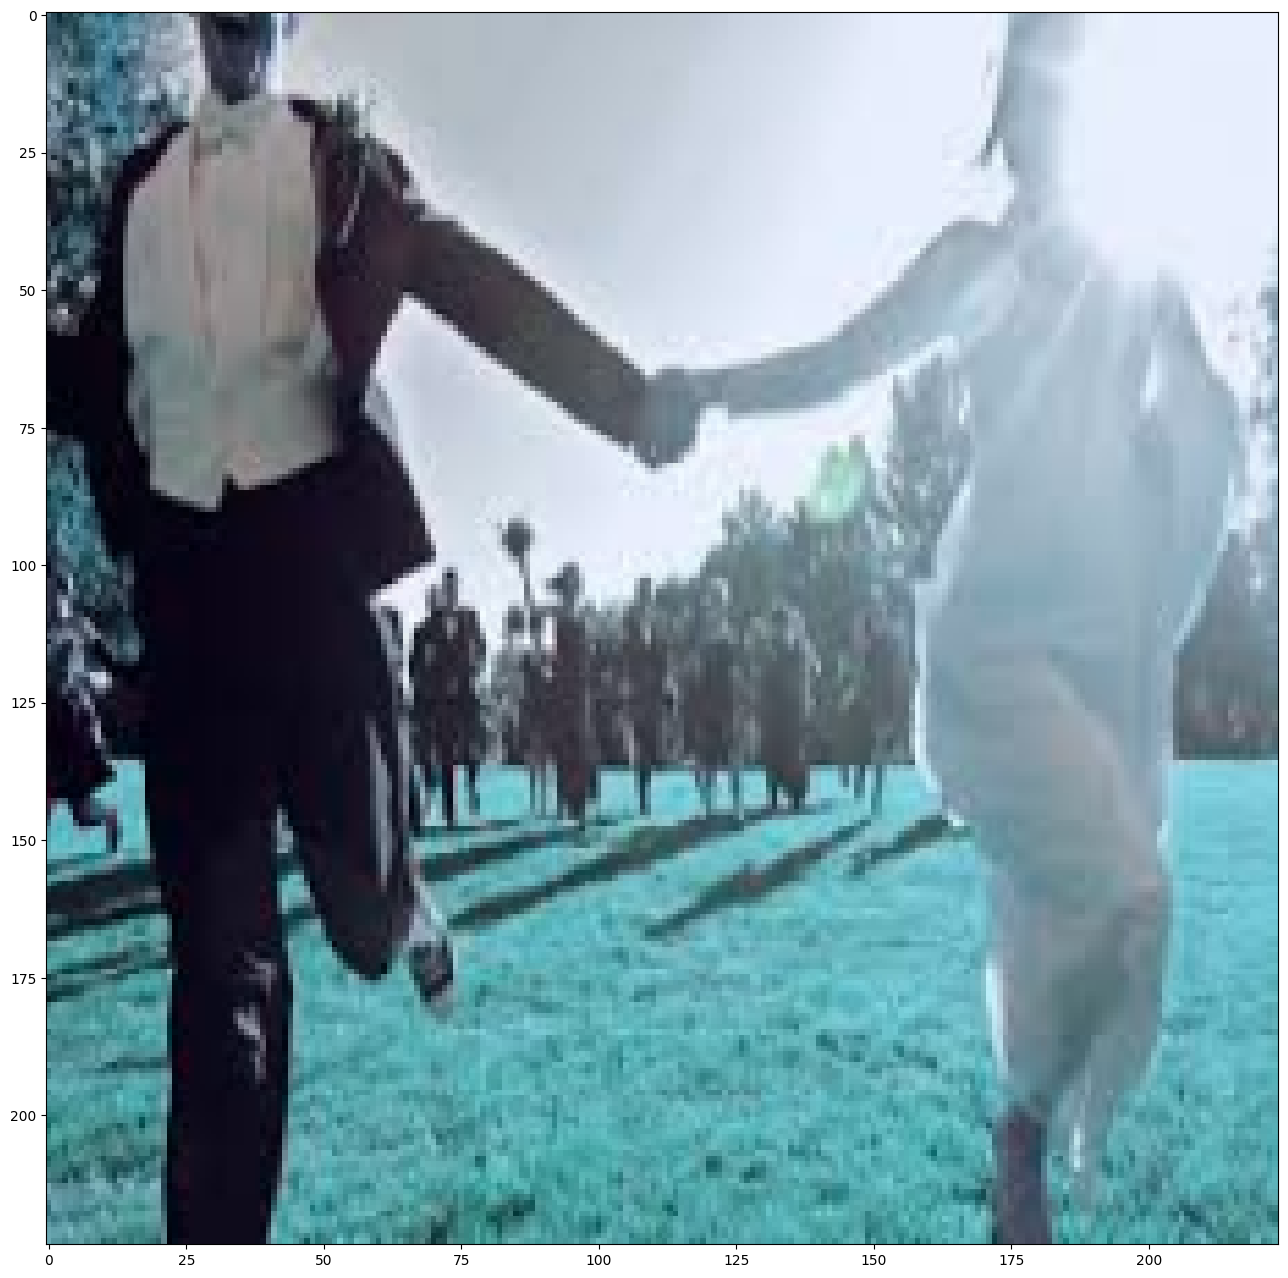

In [12]:
plt.figure(figsize=(16,16))
plt.imshow(cv2.imread(train_run[4]))

In [21]:
def dataug(files, labels, batch_size =50, randomized = True, random_seed = 1):
  randomizer = np.random.RandomState(random_seed)
  img_batch = []
  label_batch = []
  while True:
    ind = np.arange(len(files))
    if randomized:
      randomizer.shuffle(ind)
      for index in ind:
        image = cv2.imread(files[index])[:,:,0:3]/255
        label = labels[index]
        img_batch.append(image)
        label_batch.append(label)
        if len(img_batch) == batch_size:
          yield np.array(img_batch),np.array(label_batch)
          img_batch = []
          label_batch = []
      if len(img_batch)>0:
          yield np.array(img_batch),np.array(label_batch)
          img_batch = []
          label_batch = []




In [22]:
transfered = InceptionV3(include_top=False, weights='imagenet', input_tensor = None, input_shape=(None, None, 3), pooling='avg',classes = 1000)
model = Sequential()
model.add((InputLayer(None,None,3)))
model.add(transfered)
model.add(Dropout(0.5))
model.add(Dense(1, activation = 'sigmoid'))


In [25]:
transfered.trainable = False
model.compile(optimizer = 'adam', loss= 'binary_crossentropy', metrics = ['acc'])
batch_size = 500
epochs = 1

In [26]:
from keras.callbacks import ModelCheckpoint


model.fit(dataug(train['file'], train['label'], batch_size=batch_size, randomized=True, random_seed=1),
          steps_per_epoch=int(np.ceil(len(train) / batch_size)),
          epochs=epochs,
          validation_data=dataug(test['file'], test['label'], batch_size=batch_size, randomized=True),
          validation_steps=int(np.ceil(len(test) / batch_size)),
          callbacks=[ModelCheckpoint(filepath='./weights.hdf5', monitor='val_loss', verbose=0, save_best_only=True)],
          verbose=2)


2/2 - 137s - loss: 0.7279 - acc: 0.5567 - val_loss: 0.8198 - val_acc: 0.4255 - 137s/epoch - 69s/step


In [29]:
transfered.trainable=True
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
batch_size=500
epochs=1

In [ ]:
model.fit(dataug(train['file'],train['label'],batch_size=batch_size,randomized=True,random_seed=1),steps_per_epoch=int(np.ceil(len(train)/batch_size)), epochs=epochs,
          validation_data=dataug(test['file'],test['label'],batch_size=batch_size,randomized=True),validation_steps=int(np.ceil(len(test)/batch_size)),
          callbacks=[ModelCheckpoint(filepath='./weights.hdf5',monitor='val_loss',verbose=0,save_best_only=True)],
          verbose=2)
model.load_weights('weights.hdf5')

In [ ]:
model.save('model_final.h5')